## Biomass statistics per production level

Data from [Fiskeridirektoratet](https://www.fiskeridir.no/Akvakultur/Tall-og-analyse/Biomassestatistikk/Biomassestatistikk-etter-produksjonsomraade)

### 1. Importing data

In [74]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from helpers.dicts import traffic_light
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import scipy as sp
pd.set_option('display.float_format', '{:.6f}'.format)

In [2]:
with open("input/biomasse.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data["Data"])

### 2. Cleaning data

* Standardization: Round "BIOMASSE_KG" to integer
* Merge: "TRAFFIC_LIGHTS" based on helpers/dicts.py
* Define "DATO" as a datetime
* Sum "UTSETTSÅR"
* Remove 2024
* Remove rainbow trout

In [3]:
df["BIOMASSE_KG"] = df["BIOMASSE_KG"].round().astype(int)
df["TRAFFIC_LIGHT"] = df["PO_KODE"].map(lambda x: traffic_light.get(x, {}).get("light"))
df["DATO"] = pd.to_datetime(df["ÅR"].astype(str) + "-" + df["MÅNED_KODE"].astype(str))
clean_df = df.groupby(["DATO", "PO_KODE", "PO_NAVN", "ARTSID", "TRAFFIC_LIGHT"]).agg({"BEHFISK_STK": "sum", "BIOMASSE_KG": "sum"}).reset_index()
clean_df = clean_df[(clean_df["DATO"].dt.year != 2024) & (clean_df["DATO"].dt.year != 2017)]
clean_df = clean_df[clean_df["ARTSID"] == "LAKS"]

### 3. Functions

* montly_laks: Takes the argument "red", "yellow" or "green" and returns a dataframe with the locations that matches the color. 
* pval: Computes the pvalue and slope for each location area and return a dataframe.
* dato_formatter: Calculates the unix timestamp back to readable date format.

In [34]:
def monthly_laks(df, color):
    laks_df = df[(df["TRAFFIC_LIGHT"] == color) & (df['ARTSID'] == "LAKS")].copy()
    laks_df["DATO"] = pd.to_datetime(laks_df["DATO"])
    return laks_df

def pval(data):
    pval_rows = []
    for name in data["PO_NAVN"].unique():
        data_temp = data.query("PO_NAVN==@name")
        r, p = sp.stats.pearsonr(data_temp["DATO"], data_temp["BIOMASSE_KG"])
        pval_rows.append({"name": name, "pvalue": p, "slope": r})
    df_pvalue = pd.DataFrame(pval_rows)
    return df_pvalue

def dato_formatter():
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    return None

### 4. Processing data

##### 4.1 Histogram of biomass

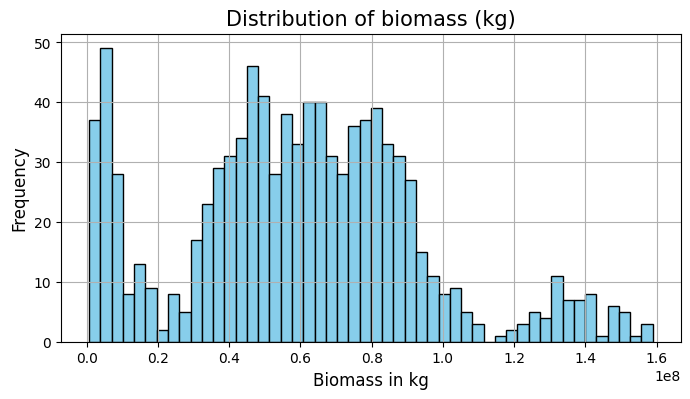

In [76]:
plt.figure(figsize=(8, 4))
clean_df["BIOMASSE_KG"].plot.hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of biomass (kg)", fontsize=15)
plt.xlabel("Biomass in kg", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()

##### 4.2 Statistical numbers

In [22]:
green = monthly_laks(clean_df, "green")["BIOMASSE_KG"].describe().round().astype(int)
yellow = monthly_laks(clean_df, "yellow")["BIOMASSE_KG"].describe().round().astype(int)
red = monthly_laks(clean_df, "red")["BIOMASSE_KG"].describe().round().astype(int)

describe = pd.concat([green, yellow, red], axis=1, join="inner")
describe.columns = ["Green", "Yellow", "Red"]
describe

,Green,Yellow,Red
count,576,144,216
mean,60949458,51004619,62933749
std,40257287,12073579,23724271
min,681183,21543098,22256850
25%,28627614,43386810,43119571
50%,65684241,49419212,58994839
75%,83202614,59958781,85750210
max,158886917,79616926,110028531


##### 4.3 Line plot of red area

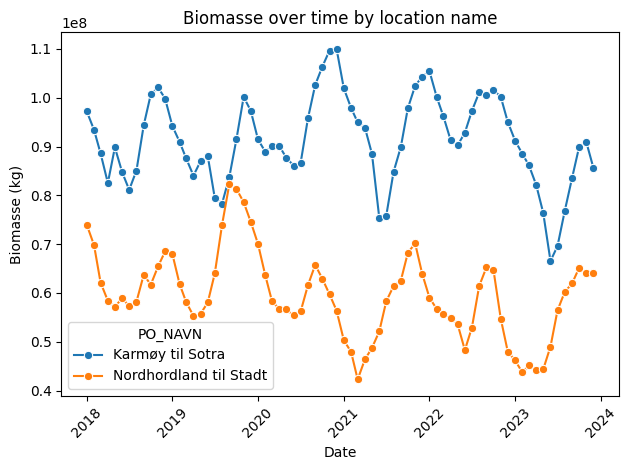

In [40]:
laks_line = monthly_laks(clean_df, "red")
lineplot = sns.lineplot(data=laks_line, x='DATO', y='BIOMASSE_KG', hue='PO_NAVN', marker='o')
plt.xticks(rotation=45)
plt.title("Biomasse over time by location name")
plt.xlabel("Date")
plt.ylabel("Biomasse (kg)")
plt.legend(title="PO_NAVN")
plt.tight_layout()
plt.show()

### 5. Results

##### 5.1 Green areas

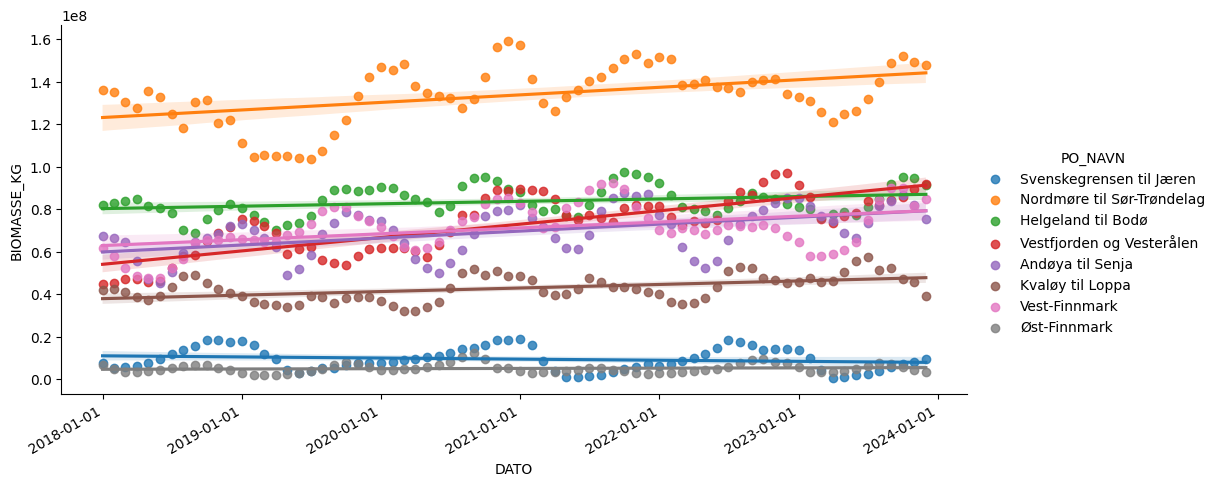

In [49]:
laks_green = monthly_laks(clean_df, "green")
laks_green['DATO'] = mdates.date2num(laks_green['DATO'])
laks = sns.lmplot(data=laks_green, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.2 Yellow areas

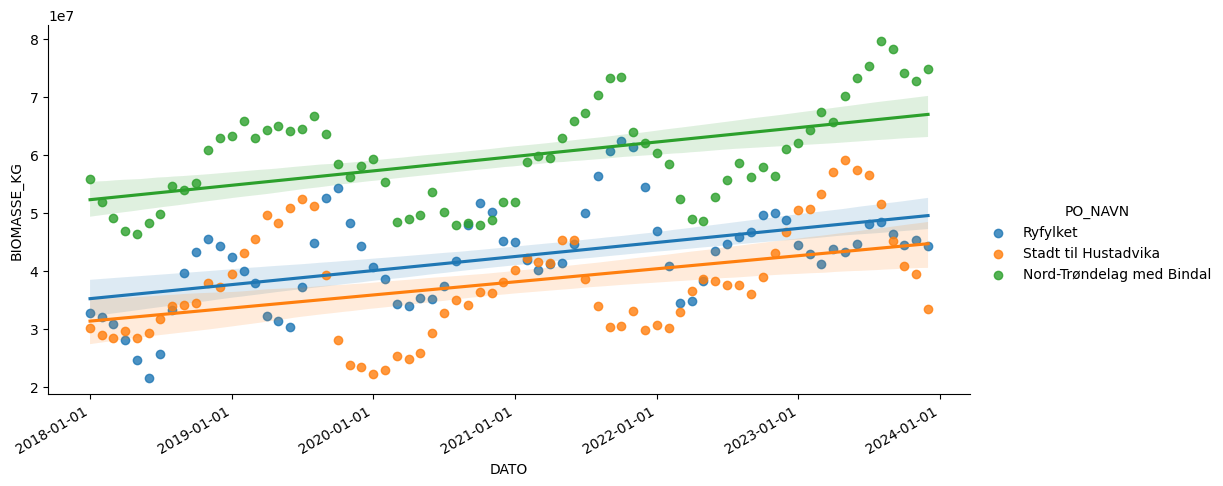

In [37]:
laks_yellow = monthly_laks(clean_df, "yellow")
laks_yellow['DATO'] = mdates.date2num(laks_yellow['DATO'])
laks = sns.lmplot(data=laks_yellow, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.3 Red areas

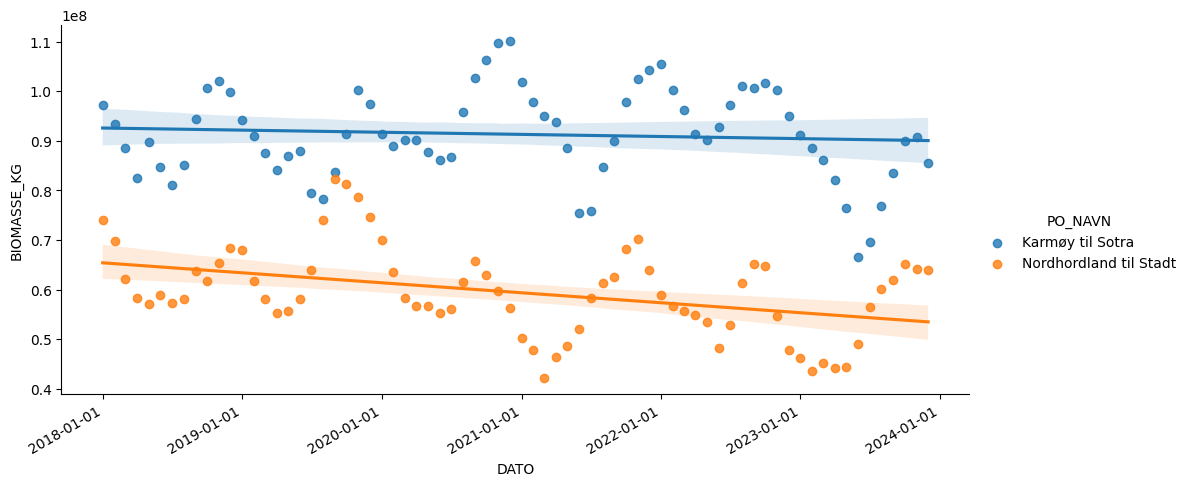

In [38]:
laks_red = monthly_laks(clean_df, "red")
laks_red['DATO'] = mdates.date2num(laks_red['DATO'])
laks = sns.lmplot(data=laks_red, x="DATO", y="BIOMASSE_KG", hue="PO_NAVN", aspect=2)
dato_formatter()
plt.show()

##### 5.4 P-values and slope values

In [73]:
pvalue_green = pval(laks_green).round(6)
pvalue_yellow = pval(laks_yellow).round(6)
pvalue_red = pval(laks_red).round(6)
pvalue_green["color"] = "green"
pvalue_yellow["color"] = "yellow"
pvalue_red["color"] = "red"
pvalues = pd.concat([pvalue_green, pvalue_yellow, pvalue_red]).reset_index(drop=True)
pvalues 

,name,pvalue,slope,color
0,Svenskegrensen til Jæren,0.158021,-0.168133,green
1,Nordmøre til Sør-Trøndelag,0.000073,0.450101,green
2,Helgeland til Bodø,0.014346,0.287467,green
3,Vestfjorden og Vesterålen,0.000000,0.791276,green
4,Andøya til Senja,0.000004,0.515532,green
5,Kvaløy til Loppa,0.000017,0.483223,green
6,Vest-Finnmark,0.000080,0.447938,green
7,Øst-Finnmark,0.358700,0.109763,green
8,Ryfylket,0.000004,0.512318,yellow
9,Stadt til Hustadvika,0.000177,0.427931,yellow
